In [1]:
# import logging
# logging.getLogger('tenpy').setLevel(logging.WARNING)

from tenpy.models.spins import SpinChain
from tenpy.networks.mps import MPS, InitialStateBuilder
from tenpy.algorithms.tebd import RandomUnitaryEvolution
from tenpy.algorithms import dmrg
from tenpy.networks.mpo import MPO
from tenpy.models.aklt import AKLTChain
from tenpy.algorithms import dmrg
from tenpy.networks.purification_mps import PurificationMPS

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
import time
import seaborn as sns




## Numerical ground state search via finite DMRG

In [2]:
def generate_random_mps(model, psi0=None, chi_max=50, N_steps=20):

    """    Generate a random MPS for the given model and evolve it using a random unitary evolution.
    Args:
        model: The model for which the MPS is generated.
        psi0: Initial state of the MPS, if None, a product state of "0.0" is used.
        chi_max: Maximum bond dimension for the MPS.
        N_steps: Number of steps for the random unitary evolution.
    Returns:
        psi: The evolved MPS after the random unitary evolution.
    """



    sites = model.lat.mps_sites()
    L = model.lat.N_sites
    if psi0 is None:
        psi0 = ["0.0"] * L
    psi = MPS.from_product_state(sites, psi0 , bc=model.lat.bc_MPS)

    rand_opts = {
        'N_steps': N_steps,
        'trunc_params': {'chi_max': chi_max},
        'dt': 1.0
    }
    engine = RandomUnitaryEvolution(psi, rand_opts)
    engine.run()
    psi.canonical_form()

    return psi

In [3]:
# Settings for the DMRG algorithm

L = 50
chi_max = 20

model = AKLTChain({'L': L, 'bc_MPS': 'finite'})
psi_gs = model.psi_AKLT()  


dmrg_params = {
    'mixer': True,
    'max_E_err': 1e-8,
    'max_sweeps': 20,
    'min_sweeps': 6,
    'trunc_params': {'chi_max': chi_max},
    # 'max_trunc_err': 1e-6,
    # 'E_tol_to_trunc': 1e-6,
    # 'P_tol_to_trunc': 1e-6
}

possible_states = ["down", "up", "0.0"]
biased_states =  [[i]+["0.0"] * (L - 2)+[j] for i in possible_states for j in possible_states] # a list of states we might like to start the DMRG with
# biased_states[0]

In [19]:
psi_rand = generate_random_mps(model, chi_max=chi_max, N_steps=10)
psi_init = psi_rand.copy()
dmrg_engine = dmrg.TwoSiteDMRGEngine(psi_init, model, dmrg_params)
E0, psi_dmrg = dmrg_engine.run()

In [5]:
bond_energies_initial = model.bond_energies(psi_rand)
print("Bond energies of the random MPS:", bond_energies_initial)
print('bond dimensions:\n', psi_rand.chi, '\n')


bond_energies_final = model.bond_energies(psi_dmrg)
print("\nBond energies of the final MPS:", bond_energies_final)
print('bond dimensions:\n', psi_dmrg.chi)


Bond energies of the random MPS: [0.53026512 0.37482182 0.32281527 0.39704316 0.35763334 0.36536503
 0.36482544 0.30237037 0.39068564 0.30671358 0.30984617 0.30854944
 0.36913199 0.3219005  0.37128902 0.37017659 0.34302442 0.29882482
 0.28113883]
bond dimensions:
 [3, 9, 27, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 27, 9, 3] 


Bond energies of the final MPS: [-0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667]
bond dimensions:
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [6]:
dmrg_ground_states = []
first_excited_states = []
first_excited_energies = []
niter = 1


for biased_state in biased_states * niter:
    psi_init = generate_random_mps(model, psi0=biased_state, chi_max=chi_max, N_steps=10)
    orthogonal_states = []

    while True:
        eng = dmrg.TwoSiteDMRGEngine(psi_init, model, dmrg_params, orthogonal_to = orthogonal_states)
        E, psi_out = eng.run()
        if np.isclose(E, -(L-1)*2/3, atol=1e-5, rtol=1e-4):
            orthogonal_states.append(psi_out.copy())
            print('Found ground state with energy:', E)
        else:
            first_excited_states.append(psi_out.copy())
            first_excited_energies.append(E)
            dmrg_ground_states += orthogonal_states
            break



Found ground state with energy: -12.666666666666682
Found ground state with energy: -12.666666666666687


final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=5.95e-05


Found ground state with energy: -12.666666666666671
Found ground state with energy: -12.666666666666677
Found ground state with energy: -12.666666666666663


final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=2.51e-05


Found ground state with energy: -12.666666666666687
Found ground state with energy: -12.666666666666682
Found ground state with energy: -12.666666666666675
Found ground state with energy: -12.666666666666675
Found ground state with energy: -12.66666666666666


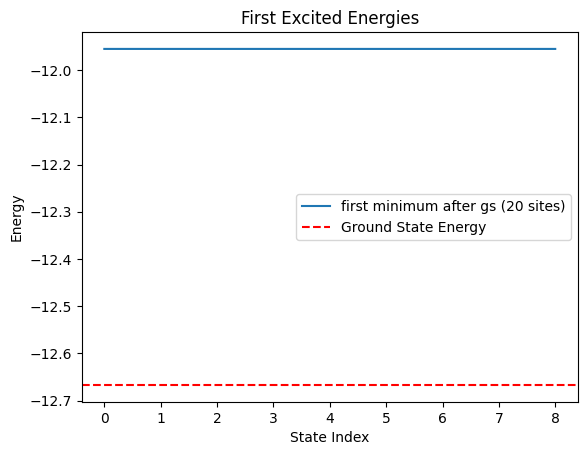

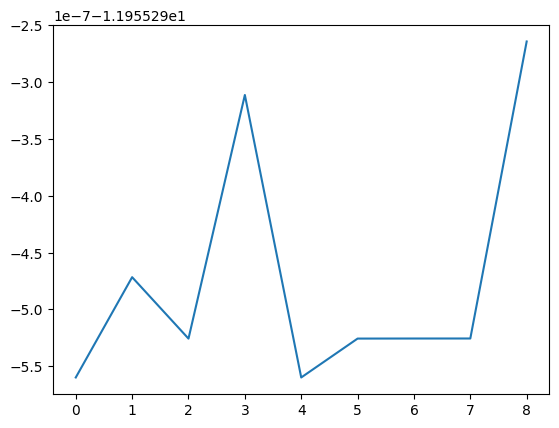

In [7]:
plt.plot(first_excited_energies, label=f'first minimum after gs ({L} sites)')
plt.axhline(y=-(L-1)*2/3, color='r', linestyle='--', label='Ground State Energy')
plt.xlabel('State Index')
plt.ylabel('Energy')
plt.title('First Excited Energies')
plt.legend()
plt.show()
plt.plot(first_excited_energies, label='first minimum after gs')
plt.show()

In [8]:
energy_gap = np.min(first_excited_energies)+(L-1)*2/3

print("Energy gap:", energy_gap)

Energy gap: 0.7113761066937325


In [9]:
N = len(dmrg_ground_states)
overlap_matrix = np.zeros((N, N), dtype=np.complex128)

for i in range(N):
    for j in range(N):
        overlap_matrix[i, j] = dmrg_ground_states[i].overlap(dmrg_ground_states[j])

OL_mat = np.round(np.abs(overlap_matrix), 3)

In [10]:
# we eliminate the states that overlap with the selected state and iterate until no states are left
selected_indices = []
remaining = set(range(len(OL_mat)))

while remaining:
    i = min(remaining)
    selected_indices.append(i)
    
    overlapping = set(np.where(OL_mat[i] > 0)[0])
    
    remaining -= overlapping

print(f"Estimated degeneracy: {len(selected_indices)}")
print("Selected orthogonal state indices:", selected_indices)


Estimated degeneracy: 4
Selected orthogonal state indices: [0, 1, 2, 5]


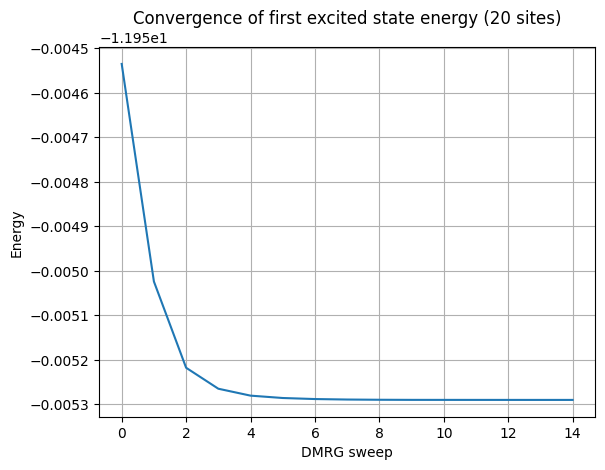

In [11]:
energies = eng.sweep_stats.get('E')
plt.plot(energies)
plt.xlabel("DMRG sweep")
plt.ylabel("Energy")
plt.title(f"Convergence of first excited state energy ({L} sites)")
plt.grid(True)
plt.show()


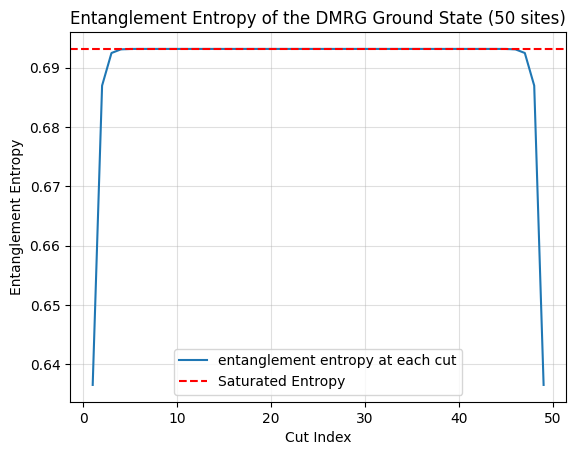

In [32]:
ee = psi_dmrg.entanglement_entropy()
plt.plot(np.arange(1,psi_dmrg.L), ee[:], label='entanglement entropy at each cut')
plt.title(f'Entanglement Entropy of the DMRG Ground State ({L} sites)')
plt.grid(alpha=0.4)
plt.xlabel('Cut Index')
plt.ylabel('Entanglement Entropy')
plt.axhline(y=np.log(2), color='r', linestyle='--', label='Saturated Entropy')
plt.legend()
plt.show()

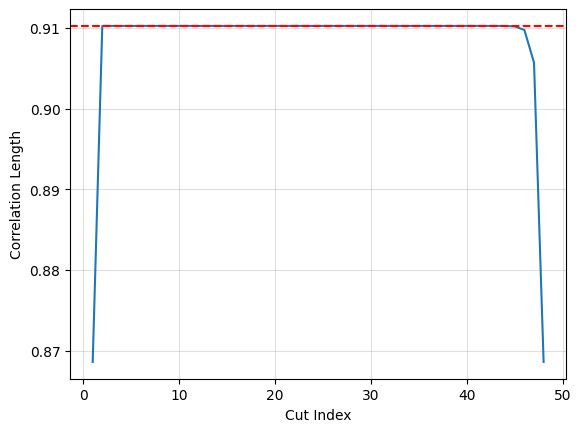

In [35]:
corr_lengths = []
for i in np.arange(1,psi_dmrg.L-1):

    A = psi_dmrg._B[i].to_ndarray().copy()

    E = np.tensordot(A, np.conj(A), axes=(1, 1)) # the transfer matrix
    E = np.transpose(E, (0, 2, 1, 3))
    E = E.reshape(A.shape[0]**2, A.shape[2]**2)

    vals, vecs = eigs(E, k=2, which='LM')


    vals
    vals = np.sort(np.abs(vals))[::-1]

    if vals[1] > 0:
        xi = -1 / np.log(vals[1])
    else:
        xi = np.inf

    corr_lengths.append(xi)


plt.plot(np.arange(1,psi_dmrg.L-1), corr_lengths, label=f'correlation length at each cut ({L} sites)')
plt.xlabel('Cut Index')
plt.ylabel('Correlation Length')
plt.grid(alpha=0.4)
plt.axhline(y=0.9102392289240578, color='r', linestyle='--', label='Correlation Length for closed boundary')
plt.show()

In [ ]:
psi_dmrg.correlation_length()
# closed boundary conditions only

np.float64(0.9102392289240578)

Finished DMRG for L=4, chi_max=4 in 0.07 seconds
Finished DMRG for L=4, chi_max=9 in 0.07 seconds
Finished DMRG for L=4, chi_max=24 in 0.08 seconds
Finished DMRG for L=4, chi_max=60 in 0.07 seconds
Finished DMRG for L=4, chi_max=150 in 0.07 seconds
Finished DMRG for L=9, chi_max=4 in 0.25 seconds
Finished DMRG for L=9, chi_max=9 in 0.47 seconds
Finished DMRG for L=9, chi_max=24 in 0.56 seconds
Finished DMRG for L=9, chi_max=60 in 0.81 seconds
Finished DMRG for L=9, chi_max=150 in 1.15 seconds
Finished DMRG for L=24, chi_max=4 in 0.77 seconds
Finished DMRG for L=24, chi_max=9 in 1.72 seconds
Finished DMRG for L=24, chi_max=24 in 2.19 seconds
Finished DMRG for L=24, chi_max=60 in 3.75 seconds
Finished DMRG for L=24, chi_max=150 in 29.79 seconds
Finished DMRG for L=60, chi_max=4 in 2.05 seconds
Finished DMRG for L=60, chi_max=9 in 4.75 seconds
Finished DMRG for L=60, chi_max=24 in 6.30 seconds
Finished DMRG for L=60, chi_max=60 in 11.75 seconds
Finished DMRG for L=60, chi_max=150 in 119.7

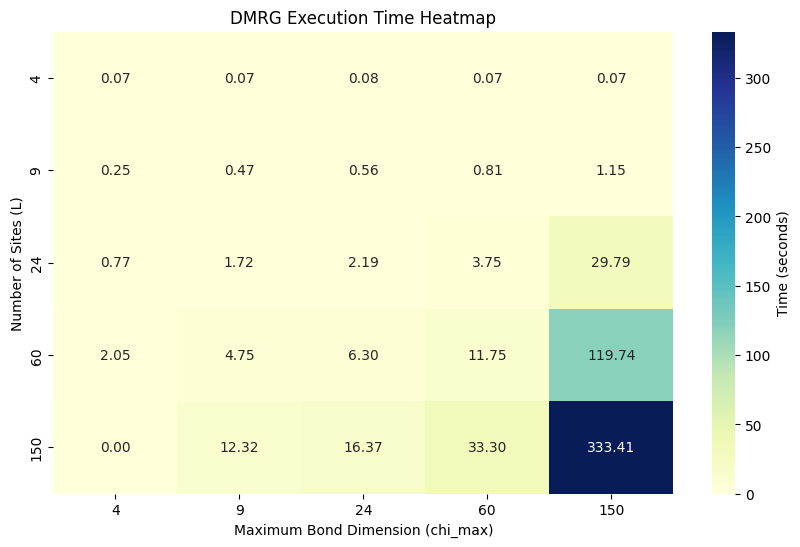

nan is the higest error for the ground state energy. seems to be nothing more than a rounding error.


In [3]:
Llist = np.logspace(np.log10(4), np.log10(150), 5, dtype=int)
CHIlist = np.logspace(np.log10(4), np.log10(150), 5, dtype=int)
Times = np.zeros((len(Llist), len(CHIlist)))
Energies = np.zeros((len(Llist), len(CHIlist)))


for i in range(len(Llist)):
    for j in range(len(CHIlist)):
        chi_max = int(CHIlist[j])
        L = int(Llist[i])
        model = AKLTChain({'L': L, 'bc_MPS': 'finite'})
        psi_gs = model.psi_AKLT()
        dmrg_params = {
            'mixer': True,
            'max_E_err': 1e-4,
            'max_sweeps': 2,
            'min_sweeps': 2,
            'trunc_params': {'chi_max': chi_max},
        }
        psi_init = generate_random_mps(model, chi_max=chi_max, N_steps=10)
        dmrg_engine = dmrg.TwoSiteDMRGEngine(psi_init, model, dmrg_params)

        try:
            start = time.time()
            E0, psi_dmrg = dmrg_engine.run()
            end = time.time()
            E0 /= (L-1)
            E0 += 2/3
        except Exception as e:
            print(f"Error for L={L}, chi_max={chi_max}: {e}")
            E0 = np.nan
            start = 0.
            end = 0.

        print(f"Finished DMRG for L={L}, chi_max={chi_max} in {end - start:.2f} seconds")


        Times[i, j] = end - start
        Energies[i, j] = E0


plt.figure(figsize=(10, 6))
sns.heatmap(Times, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=CHIlist, yticklabels=Llist,
            cbar_kws={'label': 'Time (seconds)'})
plt.title('DMRG Execution Time Heatmap')
plt.xlabel('Maximum Bond Dimension (chi_max)')
plt.ylabel('Number of Sites (L)')
plt.show()

print(f"{np.max(Energies)} is the higest error for the ground state energy. seems to be nothing more than a rounding error.")
# plt.figure(figsize=(10, 6))
# sns.heatmap(Energies, annot=True, fmt=".2f", cmap="YlGnBu",
#             xticklabels=CHIlist, yticklabels=Llist,
#             cbar_kws={'label': 'Energy'})
# plt.title('DMRG Ground State Energy error Heatmap')
# plt.xlabel('Maximum Bond Dimension (chi_max)')
# plt.ylabel('Number of Sites (L)')
# plt.show()

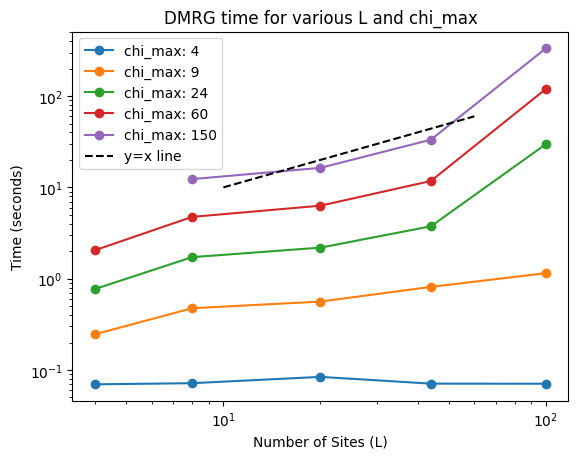

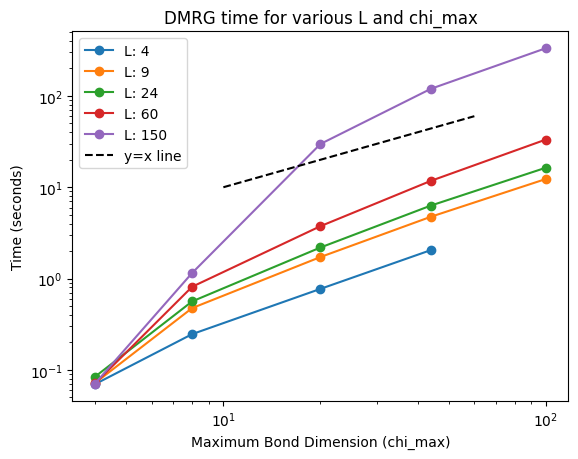

In [12]:
for i in range(len(Times)):
    row = Times[i]
    row[row == 0] = np.nan

    plt.loglog(np.logspace(np.log10(4), np.log10(100), 5, dtype=int), row, label=f"chi_max: {CHIlist[i]}", marker = "o")

plt.ylabel("Time (seconds)")
plt.xlabel("Number of Sites (L)")
plt.plot(np.arange(10,100,50), np.arange(10,100,50), ls = "--", color = "black", label = "y=x line")
plt.title("DMRG time for various L and chi_max")
plt.legend()
plt.show()


for i in range(len(Times)):
    col = Times[:,i]
    col[col == 0] = np.nan

    plt.loglog(np.logspace(np.log10(4), np.log10(100), 5, dtype=int), col, label=f"L: {Llist[i]}", marker = "o")

plt.ylabel("Time (seconds)")
plt.xlabel("Maximum Bond Dimension (chi_max)")
plt.plot(np.arange(10,100,50), np.arange(10,100,50), ls = "--", color = "black", label = "y=x line")
plt.title("DMRG time for various L and chi_max")
plt.legend()
plt.show()

In [ ]:
# # to inspect the 2 site local Hamiltonian:
# H_local = model.H_bond[1].to_ndarray()

# # to inspect the MPO at some site:
# H_MPO_example = np.round(model.H_MPO._W[0].to_ndarray(), 3)

# # to inspect the MPS at some site:
# psi_example = np.round(psi_gs._B[1].to_ndarray(), 3)